In [1]:
import findspark
findspark.init()
findspark.find
import pyspark
findspark.find()

'E:\\spark-3.0.1-bin-hadoop2.7'

In [2]:
usa_accident_file_path='C:/Users/PURUSHOTHAM REDDY/Desktop/US_Accidents_june20.csv'

In [3]:
import sys

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import plotly.graph_objects as plt_go
import math
#import vaex
import findspark
findspark.init()
import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('project').getOrCreate()
reader = spark.read
reader.option("header","true")
reader.option("inferSchema","true")

In [7]:
US_accident_data_spark = reader.csv(usa_accident_file_path)
US_accident_data_spark.show(5)

+---+--------+-----+--------+-------------------+-------------------+---------+----------+-------+-------+------------+--------------------+------+--------------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|  Source|  TMC|Severity|         Start_Time|           End_Time|Start_Lat| Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|Number|              Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition

In [8]:
print((US_accident_data_spark.count(), len(US_accident_data_spark.columns)))

(3513617, 49)


In [29]:
usa_accident_data=pd.read_csv(usa_accident_file_path)

In [30]:
usa_accident_data_filtered=usa_accident_data.drop(['Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis=1)

In [32]:
columns_null_values_count=usa_accident_data_filtered.isnull().sum(axis = 0)
columns_null_values_count  

ID                         0
Source                     0
TMC                  1034799
Severity                   0
Start_Time                 0
End_Time                   0
Start_Lat                  0
Start_Lng                  0
End_Lat              2478818
End_Lng              2478818
Distance(mi)               0
Description                1
Number               2262864
Street                     0
Side                       0
City                     112
County                     0
State                      0
Zipcode                 1069
Country                    0
Timezone                3880
Airport_Code            6758
Weather_Timestamp      43323
Temperature(F)         65732
Wind_Chill(F)        1868249
Humidity(%)            69687
Pressure(in)           55882
Visibility(mi)         75856
Wind_Direction         58874
Wind_Speed(mph)       454609
Precipitation(in)    2025874
Weather_Condition      76138
Amenity                    0
Bump                       0
Crossing      

In [33]:
for column in usa_accident_data_filtered.columns:
    if columns_null_values_count[column]>500000:
        usa_accident_data_filtered=usa_accident_data_filtered.drop([column],axis=1)

In [34]:
usa_accident_data_filtered['Year']=pd.DatetimeIndex(usa_accident_data_filtered['Start_Time']).year
usa_accident_data_filtered['Month']=pd.DatetimeIndex(usa_accident_data_filtered['Start_Time']).month
usa_accident_data_filtered['Week_day']=pd.DatetimeIndex(usa_accident_data_filtered['Start_Time']).dayofweek
usa_accident_data_filtered['Week']=pd.DatetimeIndex(usa_accident_data_filtered['Start_Time']).week
usa_accident_data_filtered['Hour']=pd.DatetimeIndex(usa_accident_data_filtered['Start_Time']).hour

In [27]:
def column_group_count(df,column):
    new_df=pd.DataFrame(df.groupby(column).size()).reset_index()
    new_df.columns=[column,'Number_of_accidents']
    return new_df

def accidents_per_severity(df,severity,feature):
    severity_df=df[df['Severity']==severity]
    return column_group_count(severity_df,feature)

def bar_plot_by_severity(df,feature,subplot,severity,rotation):
    subplot.set_title("Accidents Per "+ feature + " of Severity "+ str(severity) )
    subplot.set_xlabel(feature)
    subplot.set_ylabel("Accident Count")
    subplot.tick_params('x',labelrotation=rotation)
    subplot.bar(df[feature],df['Number_of_accidents'])

In [36]:
data_source_df=column_group_count(usa_accident_data_filtered,'Source')


In [9]:
columns_to_drop = ['Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
US_accident_data_spark = US_accident_data_spark.drop(*columns_to_drop)

In [10]:
col_names = US_accident_data_spark.schema.names
null_values_each_col = {}
for name in col_names:
    null_values_each_col[name] = US_accident_data_spark.where(US_accident_data_spark[name].isNull()).select(name).count()
null_values_each_col

{'ID': 0,
 'Source': 0,
 'TMC': 1034799,
 'Severity': 0,
 'Start_Time': 0,
 'End_Time': 0,
 'Start_Lat': 0,
 'Start_Lng': 0,
 'End_Lat': 2478818,
 'End_Lng': 2478818,
 'Distance(mi)': 0,
 'Description': 1,
 'Number': 2262864,
 'Street': 0,
 'Side': 0,
 'City': 112,
 'County': 0,
 'State': 0,
 'Zipcode': 1069,
 'Country': 0,
 'Timezone': 3880,
 'Airport_Code': 6758,
 'Weather_Timestamp': 43323,
 'Temperature(F)': 65732,
 'Wind_Chill(F)': 1868249,
 'Humidity(%)': 69687,
 'Pressure(in)': 55882,
 'Visibility(mi)': 75856,
 'Wind_Direction': 58874,
 'Wind_Speed(mph)': 454609,
 'Precipitation(in)': 2025874,
 'Weather_Condition': 76138,
 'Amenity': 0,
 'Bump': 0,
 'Crossing': 0,
 'Give_Way': 0,
 'Junction': 0,
 'No_Exit': 0,
 'Railway': 0,
 'Roundabout': 0,
 'Station': 0,
 'Stop': 0,
 'Traffic_Calming': 0,
 'Traffic_Signal': 0,
 'Turning_Loop': 0,
 'Sunrise_Sunset': 115}

In [11]:
cols_more_than_500000_missing_values = []
for i in null_values_each_col:
    if null_values_each_col[i] > 500000:
        cols_more_than_500000_missing_values.append(i)
        
US_accident_data_spark = US_accident_data_spark.drop(*cols_more_than_500000_missing_values)

In [12]:
print("Dataframe has",len(US_accident_data_spark.columns),"no of columns after drop operation")

Dataframe has 40 no of columns after drop operation


In [13]:
from pyspark.sql.functions import month, year, hour, weekofyear, dayofweek
US_accident_data_spark = US_accident_data_spark.withColumn('Month',month(US_accident_data_spark.Start_Time))
US_accident_data_spark = US_accident_data_spark.withColumn('Year',year(US_accident_data_spark.Start_Time))
US_accident_data_spark = US_accident_data_spark.withColumn('Hour',hour(US_accident_data_spark.Start_Time))
US_accident_data_spark = US_accident_data_spark.withColumn('Week_of_Year',weekofyear(US_accident_data_spark.Start_Time))
US_accident_data_spark = US_accident_data_spark.withColumn('Day_of_week',dayofweek(US_accident_data_spark.Start_Time))



In [14]:
len(US_accident_data_spark.columns)

45

In [15]:
US_accident_data_spark.createOrReplaceTempView("US_accidents")

# Analysis

## From where the data came?

In [16]:
data_source_df_spark = spark.sql("""
    SELECT Source, COUNT(ID) AS Number_Of_Accidents FROM US_accidents
    GROUP BY Source
    ORDER BY Number_Of_Accidents DESC
    """)
data_source_df_spark.show() 

+-------------+-------------------+
|       Source|Number_Of_Accidents|
+-------------+-------------------+
|     MapQuest|            2414301|
|         Bing|            1034799|
|MapQuest-Bing|              64517|
+-------------+-------------------+



#### Analysis
- Here, as we can see, around >70% data come from the MapQuest API. The the rest of the data came from the Bing APIand MapQuest-Bing APIs.

## How many accidents occur by each severity?

In [25]:
severity_df_spark = spark.sql("""
    SELECT Severity, COUNT(ID) AS Number_Of_Accidents FROM US_accidents
    GROUP BY Severity
    ORDER BY Number_Of_Accidents DESC
""")

severity_df_spark.show()

+--------+-------------------+
|Severity|Number_Of_Accidents|
+--------+-------------------+
|       2|            2373210|
|       3|             998913|
|       4|             112320|
|       1|              29174|
+--------+-------------------+



In [37]:
severity_df=column_group_count(usa_accident_data_filtered,'Severity')
severity_df = severity_df.sort_values(ascending=False,by='Number_of_accidents')
severity_df

,Severity,Number_of_accidents
1,2,2373210
2,3,998913
3,4,112320
0,1,29174


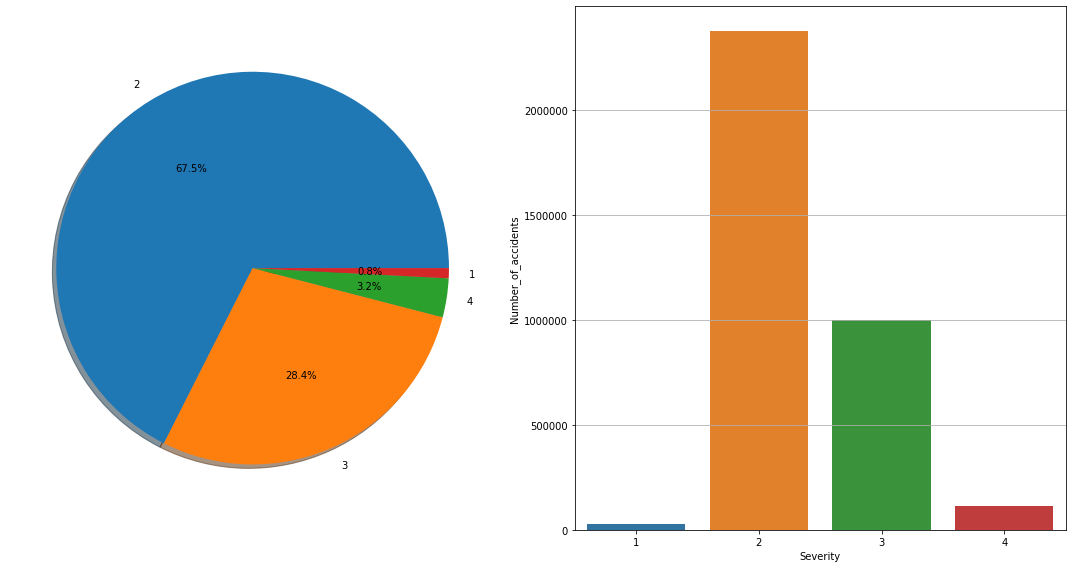

In [38]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
ax1.pie(severity_df['Number_of_accidents'],labels= ['2','3','4','1'],autopct = ('%1.1f%%'),shadow=True)
ax2.set_xlabel('Severity')
ax2.set_ylabel('Number of Accidents')
ax2.set_xticks(range(1,5))
ax2.grid()
sns.barplot(severity_df['Severity'],severity_df['Number_of_accidents'])
plt.tight_layout()
plt.show()

## How many accidents occur in each state?

In [39]:
per_state_accidents_count=column_group_count(usa_accident_data_filtered,'State')
per_state_accidents_count = per_state_accidents_count.sort_values(ascending=False,by='Number_of_accidents').reset_index(drop=True)

In [40]:
per_state_accidents_count_spark = spark.sql("""
    SELECT State, COUNT(ID) AS Number_Of_Accidents FROM US_accidents
    GROUP BY State
    ORDER BY Number_Of_Accidents DESC
""")

per_state_accidents_count_spark.show()

+-----+-------------------+
|State|Number_Of_Accidents|
+-----+-------------------+
|   CA|             816825|
|   TX|             329284|
|   FL|             258002|
|   SC|             173277|
|   NC|             165958|
|   NY|             160817|
|   PA|             106787|
|   IL|              99692|
|   VA|              96075|
|   MI|              95983|
|   GA|              93614|
|   OR|              90122|
|   MN|              81863|
|   AZ|              78584|
|   TN|              69895|
|   WA|              68544|
|   OH|              66139|
|   LA|              61515|
|   OK|              60003|
|   NJ|              59059|
+-----+-------------------+
only showing top 20 rows



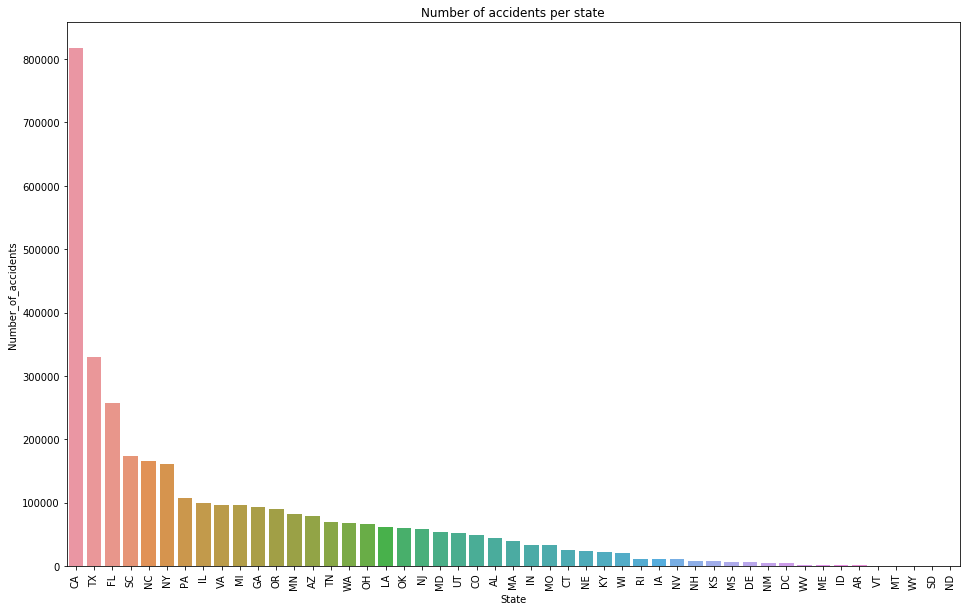

In [41]:
plt.figure(figsize=(16,10))
plt.xticks(rotation=90)
plt.title('Number of accidents per state')
sns.barplot(x="State",y="Number_of_accidents",data=per_state_accidents_count)
plt.show()

### Analysis:

- As we can see California has highest number of accidents in last 3 years, which is almost the one forth of the total accidents in United States!


In [42]:
accidents_per_state_severity_1=accidents_per_severity(usa_accident_data_filtered,1,'State').sort_values(ascending=False,by='Number_of_accidents').reset_index(drop=True)
accidents_per_state_severity_1

,State,Number_of_accidents
0,AZ,6705
1,CA,5801
2,FL,3014
3,NC,1806
4,VA,1739
5,TN,1453
6,OR,1263
7,LA,1262
8,TX,1070
9,NY,727


In [43]:
accidents_per_state_severity_1_spark = spark.sql("""
    SELECT State, COUNT(ID) AS Number_Of_Accidents FROM US_accidents 
    WHERE Severity = 1
    GROUP BY State
    ORDER BY Number_Of_Accidents DESC 

""")

accidents_per_state_severity_1_spark.show()

+-----+-------------------+
|State|Number_Of_Accidents|
+-----+-------------------+
|   AZ|               6705|
|   CA|               5801|
|   FL|               3014|
|   NC|               1806|
|   VA|               1739|
|   TN|               1453|
|   OR|               1263|
|   LA|               1262|
|   TX|               1070|
|   NY|                727|
|   WA|                531|
|   OH|                526|
|   CO|                519|
|   GA|                406|
|   UT|                395|
|   MD|                305|
|   IL|                265|
|   PA|                219|
|   MA|                183|
|   AL|                133|
+-----+-------------------+
only showing top 20 rows



In [44]:
accidents_per_state_severity_2_spark = spark.sql("""
    SELECT State, COUNT(ID) AS Number_Of_Accidents FROM US_accidents 
    WHERE Severity = 2
    GROUP BY State
    ORDER BY Number_Of_Accidents DESC 
""")

accidents_per_state_severity_2_spark.show()

+-----+-------------------+
|State|Number_Of_Accidents|
+-----+-------------------+
|   CA|             576742|
|   TX|             233840|
|   FL|             165506|
|   NC|             139050|
|   SC|             137371|
|   NY|              96064|
|   PA|              78724|
|   OR|              77747|
|   IL|              63401|
|   MI|              57060|
|   AZ|              55089|
|   OK|              53599|
|   MN|              53538|
|   VA|              51639|
|   LA|              47099|
|   TN|              45942|
|   WA|              41732|
|   OH|              41120|
|   NJ|              39160|
|   GA|              38922|
+-----+-------------------+
only showing top 20 rows



In [48]:
accidents_per_state_severity_4=accidents_per_severity(usa_accident_data_filtered,4,'State').sort_values(ascending=False,by='Number_of_accidents').reset_index(drop=True)

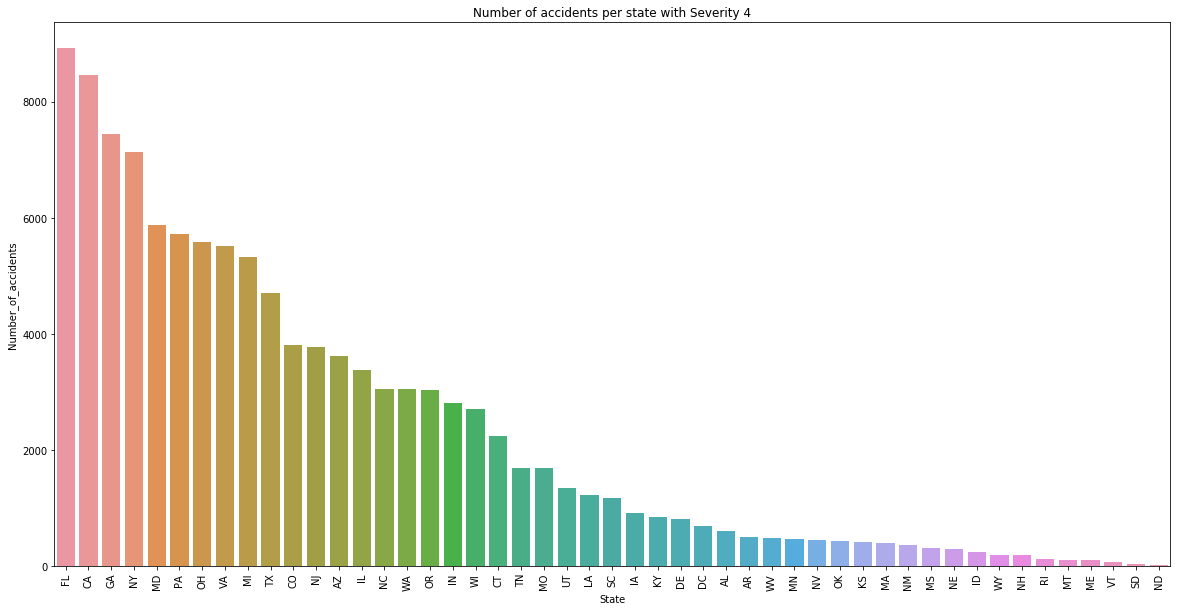

In [49]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x="State",y="Number_of_accidents",data=accidents_per_state_severity_4)
plt.title('Number of accidents per state with Severity 4')
plt.show()

### Analysis
- Here, we can see that California shifted to 2nd position for the accidents with severity 4, but most surprisingly Florida with higest accidents. 

# Top 10 places with highest number of accidents in state

In [54]:
'''county_accidents_count_spark = spark.sql("""
    SELECT County, COUNT(ID) AS Number_Of_Accidents FROM US_accidents
    GROUP BY County 
    ORDER BY Number_Of_Accidents DESC 
    LIMIT 10
""")

county_accidents_count_spark.show()'''

'county_accidents_count_spark = spark.sql("""\n    SELECT County, COUNT(ID) AS Number_Of_Accidents FROM US_accidents\n    GROUP BY County \n    ORDER BY Number_Of_Accidents DESC \n    LIMIT 10\n""")\n\ncounty_accidents_count_spark.show()'

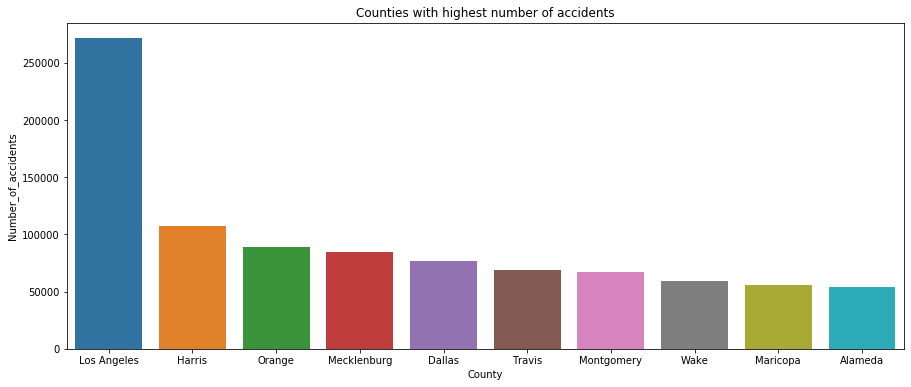

In [60]:
county_accidents_count=column_group_count(usa_accident_data_filtered,'County')
county_accidents_count=county_accidents_count.sort_values(by='Number_of_accidents',ascending=False).reset_index(drop=True)
counties_with_more_number_of_accidents=county_accidents_count.head(10)
plt.figure(figsize=(15,6))
plt.title('Counties with highest number of accidents')
plt.xlabel('County')
plt.ylabel('Number of accidents')
sns.barplot(counties_with_more_number_of_accidents['County'],counties_with_more_number_of_accidents['Number_of_accidents'])
plt.show()

### Analysis
- As we can see that the Los Angeles county has highest number of accidents, which is more than double the number of accidents in any other county. It is surprisingly huge number!

## Top 10 Counties with most number of accidents accoding to severity

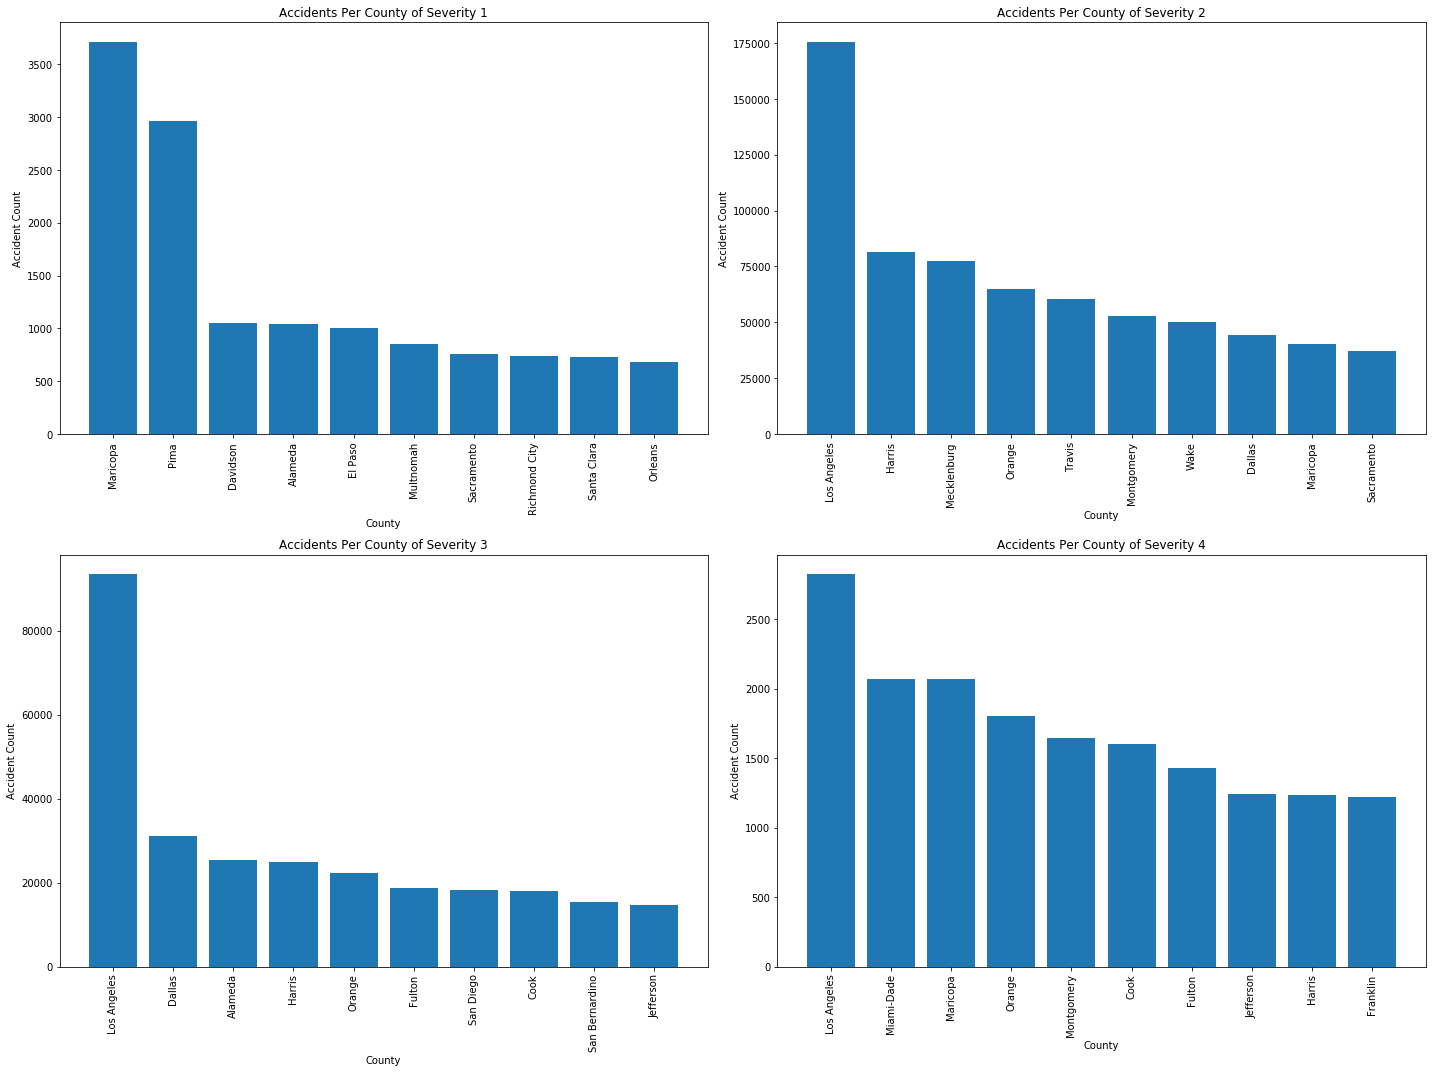

In [61]:
accidents_per_county_severity_1=accidents_per_severity(usa_accident_data_filtered,1,'County').sort_values(by='Number_of_accidents',ascending=False).reset_index(drop=True)
counties_with_more_number_of_accidents_severity_1=accidents_per_county_severity_1.head(10)
accidents_per_county_severity_2=accidents_per_severity(usa_accident_data_filtered,2,'County').sort_values(by='Number_of_accidents',ascending=False).reset_index(drop=True)
counties_with_more_number_of_accidents_severity_2=accidents_per_county_severity_2.head(10)
accidents_per_county_severity_3=accidents_per_severity(usa_accident_data_filtered,3,'County').sort_values(by='Number_of_accidents',ascending=False).reset_index(drop=True)
counties_with_more_number_of_accidents_severity_3=accidents_per_county_severity_3.head(10)
accidents_per_county_severity_4=accidents_per_severity(usa_accident_data_filtered,4,'County').sort_values(by='Number_of_accidents',ascending=False).reset_index(drop=True)
counties_with_more_number_of_accidents_severity_4=accidents_per_county_severity_4.head(10)
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(20,15))
bar_plot_by_severity(counties_with_more_number_of_accidents_severity_1,'County',ax1,1,90)
bar_plot_by_severity(counties_with_more_number_of_accidents_severity_2,'County',ax2,2,90)
bar_plot_by_severity(counties_with_more_number_of_accidents_severity_3,'County',ax3,3,90)
bar_plot_by_severity(counties_with_more_number_of_accidents_severity_4,'County',ax4,4,90)
plt.tight_layout()

### Analysis:
- Here, we have plotted the top 10 places on USA with the accidents for each severity.  
- From above four plots, it is apparent that Los Angeles County has more or less highest number of accidents of each severity.


## How many accidents occur in day and night?

In [62]:
day_night_accidents_count_spark = spark.sql("""
        SELECT Sunrise_Sunset, COUNT(ID) AS Number_Of_Accidents FROM US_accidents
        WHERE Sunrise_Sunset IS NOT NULL
        GROUP BY Sunrise_Sunset
        
""")
day_night_accidents_count_spark.show()

+--------------+-------------------+
|Sunrise_Sunset|Number_Of_Accidents|
+--------------+-------------------+
|         Night|             919745|
|           Day|            2593757|
+--------------+-------------------+



## How many accidents occur in each year?

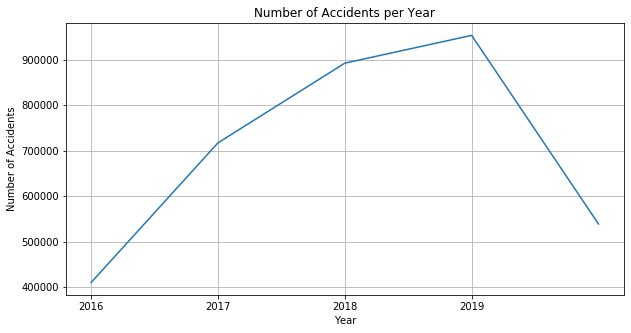

In [70]:
per_year_accidents_count=column_group_count(usa_accident_data_filtered,'Year')
per_year_accidents_count=per_year_accidents_count[(per_year_accidents_count['Year']<=2020)]
plt.figure(figsize=(10,5))
plt.plot(per_year_accidents_count['Year'],per_year_accidents_count['Number_of_accidents'])
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.grid()
plt.xticks(range(2016,2020))
plt.title('Number of Accidents per Year')
plt.show()

### Analysis
- By examining the graph, we can say that number of accidents have increased significantly every year. 2019 had more than double the number of accidents, compare to 2016.

## How many accidents occur in each month?

In [71]:
per_month_accidents_count=column_group_count(usa_accident_data_filtered,'Month')

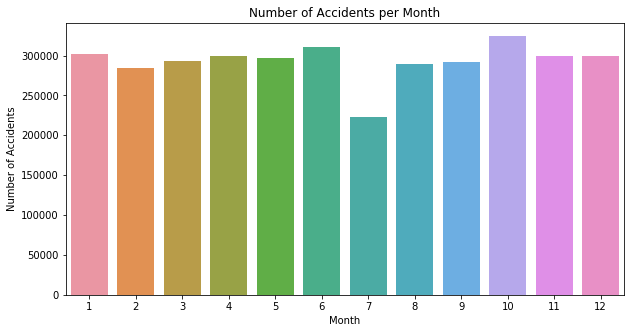

In [72]:
plt.figure(figsize=(10,5))
sns.barplot(per_month_accidents_count['Month'],per_month_accidents_count['Number_of_accidents'])
plt.xlabel('Month')
plt.xticks(range(0,12))
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents per Month')
plt.show()

### Analysis
- The number of accidents is showing a significant increase during last 5 months of a year, with a peak in october

## How many accidents occur each hour?

In [74]:

Weekday_data=usa_accident_data_filtered[(usa_accident_data_filtered['Week_day']==0) |(usa_accident_data_filtered['Week_day']==1) |(usa_accident_data_filtered['Week_day']==2) |(usa_accident_data_filtered['Week_day']==3) |(usa_accident_data_filtered['Week_day']==4)]

In [75]:
weekday_per_hour_accidents_count=column_group_count(Weekday_data,'Hour')
Weekend_data=usa_accident_data_filtered[(usa_accident_data_filtered['Week_day']==5) | (usa_accident_data_filtered['Week_day']==6)]
weekend_per_hour_accidents_count=column_group_count(Weekend_data,'Hour')


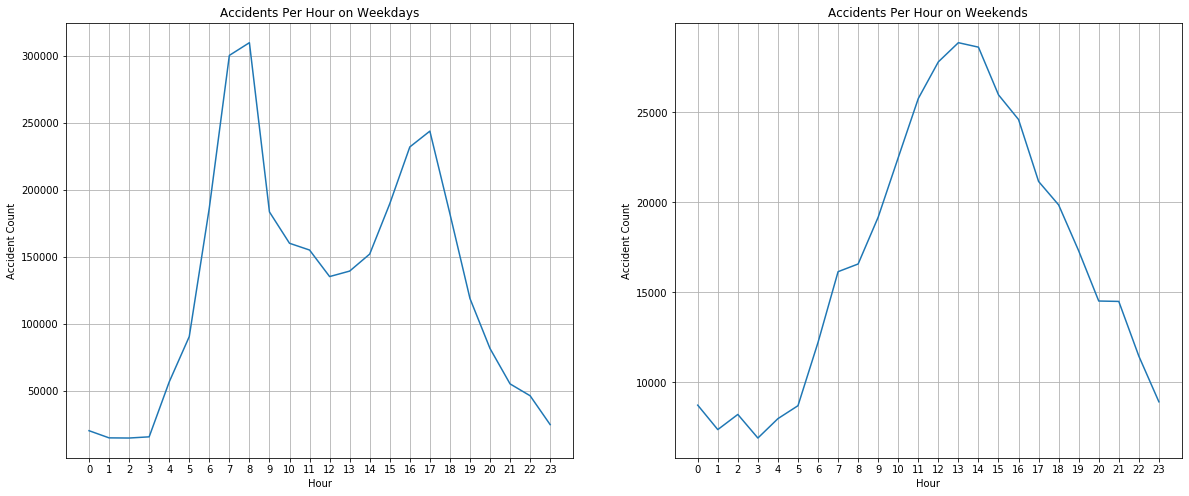

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))
ax1.plot(weekday_per_hour_accidents_count['Hour'],weekday_per_hour_accidents_count['Number_of_accidents'])
ax1.set_title("Accidents Per Hour on Weekdays" )
ax1.set_xlabel("Hour")
ax1.set_ylabel("Accident Count")
ax1.set_xticks(range(0,24))
ax1.grid()

ax2.set_title("Accidents Per Hour on Weekends" )
ax2.set_xlabel("Hour")
ax2.set_ylabel("Accident Count")
ax2.set_xticks(range(0,24))
ax2.plot(weekend_per_hour_accidents_count['Hour'],weekend_per_hour_accidents_count['Number_of_accidents'])
ax2.grid()
plt.show()

### Analysis
- As we can clearly see that accidents peak hour changed during weekdays and weekends.
- During weekdays, most of accidents occured between 7-8 in the morning and 4-5 in the evening. It might be because at that time most of the people were whether going to or coming back from their work  
- While, during weekends it was completely different. Most of the accidents occured between 12-2 in the afternoon.

## How various weather conditions affect accidents

In [77]:
per_weather_accidents_count=column_group_count(usa_accident_data_filtered,'Weather_Condition').sort_values(ascending=False,by='Number_of_accidents').reset_index(drop=True)
per_weather_accidents_count=per_weather_accidents_count.head(15)
per_weather_accidents_count

,Weather_Condition,Number_of_accidents
0,Clear,808202
1,Fair,547721
2,Mostly Cloudy,488094
3,Overcast,382485
4,Partly Cloudy,344815
5,Cloudy,212878
6,Scattered Clouds,204660
7,Light Rain,176942
8,Light Snow,50435
9,Rain,42016


<BarContainer object of 15 artists>

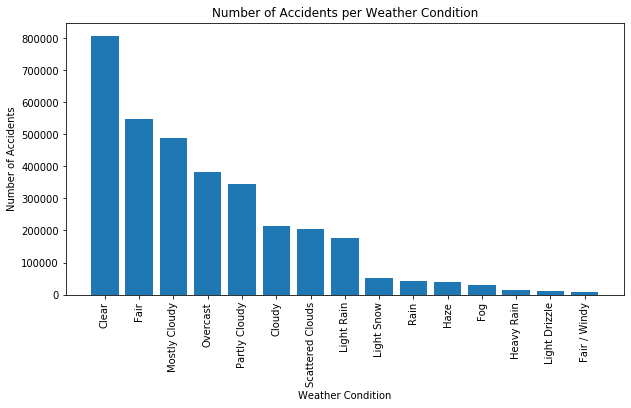

In [78]:
plt.figure(figsize=(10,5))
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents per Weather Condition')
plt.xticks(rotation=90)
plt.bar(per_weather_accidents_count['Weather_Condition'],per_weather_accidents_count['Number_of_accidents'])

### Analysis
- As we can see that most of the accidents have occured during clear weather. It was followed by, Mostly cloudly, Overcast, Fair and Partly Cloudy weathers. Surprisingly, Fog hadn't caused that much accidents, compare to other top weather conditions.

## Where the accidents have occured

In [79]:
infrastructure_dict={}
features=['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
for feature in features:
    accidents_at_traffic_signal_count=column_group_count(usa_accident_data_filtered,feature)
    accidents_at_traffic_signal_count=accidents_at_traffic_signal_count[accidents_at_traffic_signal_count[feature]==True]
    accidents_at_traffic_signal_count
    infrastructure_dict[feature]=accidents_at_traffic_signal_count.iloc[0,1]
infrastructure_dict

{'Bump': 606,
 'Crossing': 274526,
 'Give_Way': 9564,
 'Junction': 284449,
 'No_Exit': 4384,
 'Railway': 31175,
 'Roundabout': 184,
 'Station': 70321,
 'Stop': 51976,
 'Traffic_Calming': 1401,
 'Traffic_Signal': 623623}

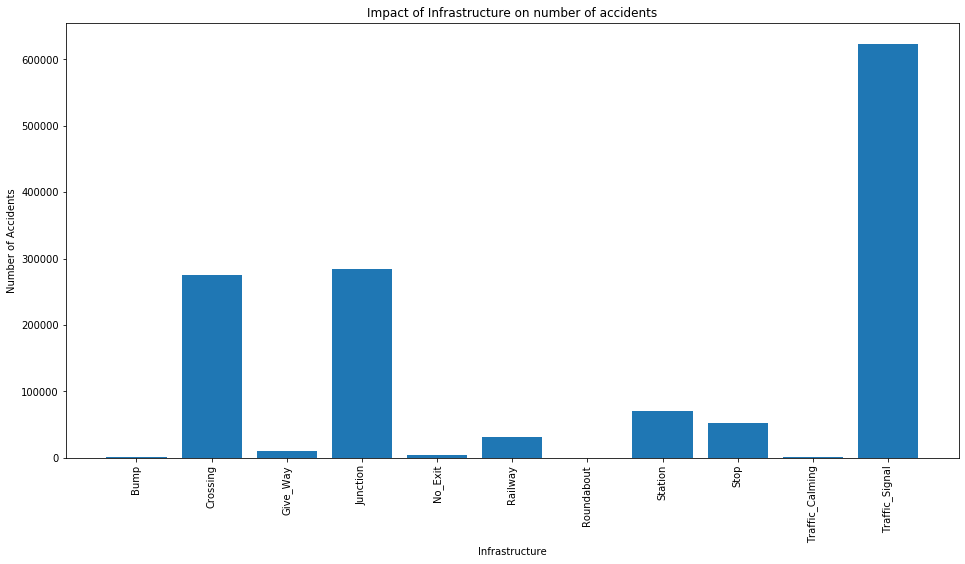

In [80]:
plt.figure(figsize=(16,8))
plt.xlabel('Infrastructure')
plt.ylabel('Number of Accidents')
plt.title('Impact of Infrastructure on number of accidents')
plt.xticks(rotation=90)
plt.bar(infrastructure_dict.keys(),infrastructure_dict.values())
plt.show()

## Analysis
- As we can see that most of the accidents have occured at Traffic Signal, Junction and Crossing. 
- We can say that most of the accidents are occuring because people may not be following traffic signal properly.

## Impact of Infrastructure on Severity of accidents

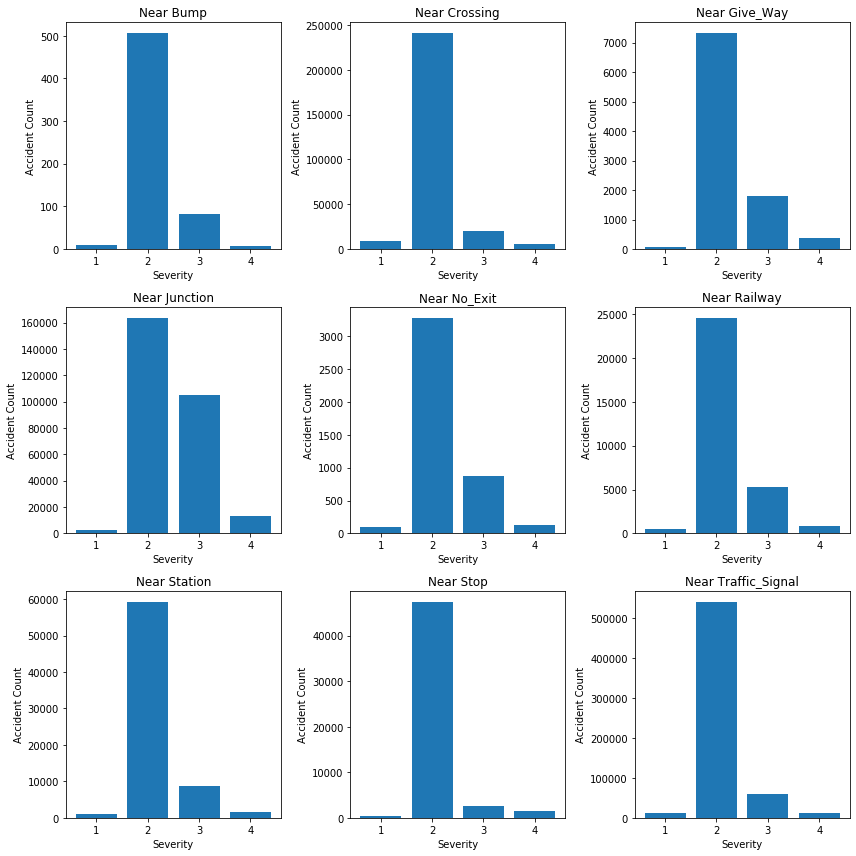

In [81]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3,figsize=(12,12))
subplots=[ax1, ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
curr_index=0
features=['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Station', 'Stop', 'Traffic_Signal']
for feature in features:
    subplot=subplots[curr_index]
    subplot.set_title("Near "+ feature)
    subplot.set_xlabel('Severity')
    subplot.set_ylabel("Accident Count")
    curr_index+=1
    subplot.set_xticks(range(1,5,1))
    plot=usa_accident_data_filtered.loc[usa_accident_data_filtered[feature] == True]['Severity'].value_counts()
    subplot.bar(plot.index,plot.values)
plt.tight_layout()
plt.show()

## Analysis
- We can clearly see that every infrastucure has more number of severity 2 accidents than any other severity.